For pure $\alpha$_iron:  
lattice constant, elastic constants, vacancy cluster formation energies, low index surface energies, Bain path, energy-volume relations (Table S4, Fig. S4)  
phonon dispersion (3x3x3 sc)  
$\gamma$ surface

1. lattice constant

In [13]:
from pyiron import Project
import numpy as np
import matplotlib.pylab as plt
import scipy.optimize
import ase.units

In [14]:
potential =  '2021--Wen-M--Fe-H--LAMMPS--ipr1'

In [15]:
pr = Project('Fe_NNIP')

In [16]:
job = pr.create_job(job_name='lattice constant', job_type='Lammps', delete_existing_job=True)
structure = pr.create.structure.bulk('Fe', crystalstructure='bcc', cubic=True)
potential =  '2021--Wen-M--Fe-H--LAMMPS--ipr1'
job.structure = structure
job.potential = potential
job.calc_minimize(pressure=[0,0,0,0,0,0])
job.run(delete_existing_job=True)

The job lattice_constant was saved and received the ID: 9477


In [17]:
structure_opt = job.get_structure(frame=-1)
structure_opt.get_cell()
a = np.linalg.norm(structure_opt.cell[0])
a

2.854875997141901

2. elastic constants

In [24]:
pr = Project("Elastic_C")

In [56]:
# structure optimization
job = pr.create.job.Lammps("optimise", delete_existing_job=True)
job.structure = pr.create.structure.bulk('Fe', crystalstructure='bcc', cubic=True)
job.potential = potential
job.calc_minimize(pressure=0.0)
job.run(delete_existing_job=True)

# get E0, V0
structure_opt = job.get_structure(frame=-1)
cell = structure_opt.cell
e0   = job.output.energy_pot[-1]
v0   = structure_opt.get_volume()

The job optimise was saved and received the ID: 9471


In [39]:
strains = [-0.01, -0.005, 0.005, 0.01]
shear_strains = [0.005, 0.01, 0.015, 0.02]

I = np.diag((1, 1, 1))

def eps(e, i, j):
    voigt_map = {1:[1, 1], 2:[2, 2], 3:[3, 3],
                 4:[2, 3], 5:[1, 3], 6:[1, 2]}

    k, l = voigt_map[i]
    eps1 = np.zeros((3, 3))
    eps1[k-1][l-1] += e/2
    eps1[l-1][k-1] += e/2
    k, l = voigt_map[j]
    eps2 = np.zeros((3, 3))
    eps2[k-1][l-1] += e/2
    eps2[l-1][k-1] += e/2


    return (eps1 + eps2)/2


data = []
for e in strains:
    D = I + eps(e, 1, 1)
    structure = structure_opt.copy()
    cell = structure_opt.cell
    structure.set_cell(D.dot(cell.T).T, scale_atoms=True)
    job = pr.create.job.Lammps("minimise", delete_existing_job=True)
    job.structure = structure
    job.potential = potential
    job.calc_minimize()
    job.run(delete_existing_job=True)
    en = job.output.energy_tot[-1] #"output/generic/energy_tot"][-1]
    v = structure.get_volume()
    data.append([e, v, en-e0])
    

The job minimise was saved and received the ID: 9470
The job minimise was saved and received the ID: 9470
The job minimise was saved and received the ID: 9470
The job minimise was saved and received the ID: 9470


<>:12: SyntaxWarning: invalid escape sequence '\%'
<>:12: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_3061675/2161885948.py:12: SyntaxWarning: invalid escape sequence '\%'
  plt.xlabel("strain (\%)")


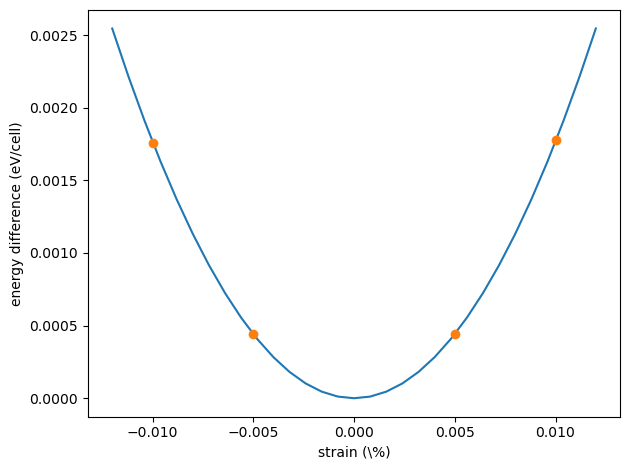

C11 = 243.45 GPa


/tmp/ipykernel_3061675/2161885948.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("C11 = %.2f GPa" %(C / ase.units.kJ * 1.0e24))


In [44]:
E = lambda eps, C: 0.5*v0 * C * eps**2

eps, volumes, energies = zip(*data)

popt = scipy.optimize.curve_fit(E, eps, energies)
C  = popt[0]

x = np.linspace(-eps[-1]*1.2, eps[-1]*1.2, 31)
plt.figure()
plt.plot(x, E(x, C))
plt.plot(eps, energies, "o")
plt.xlabel("strain (\%)")
plt.ylabel("energy difference (eV/cell)")
plt.tight_layout()
plt.show()

print("C11 = %.2f GPa" %(C / ase.units.kJ * 1.0e24))


In [32]:
job_ref = pr.create_job(job_name='et', job_type='Lammps', delete_existing_job=True)
structure = pr.create.structure.bulk('Fe', crystalstructure='bcc', cubic=True)
potential =  '2021--Wen-M--Fe-H--LAMMPS--ipr1'
job.structure = structure
job.potential = potential

In [34]:
mm = job_ref.create_job(job_type='ElasticTensor', job_name='em', delete_existing_job=True)
mm?

Type:           ElasticTensor
String form:    {'groups': [], 'nodes': []}
Length:         0
File:           ~/miniconda3/envs/pyiron/lib/python3.12/site-packages/pyiron_atomistics/atomistics/master/elastic.py
Docstring:     
Class to calculate the elastic tensor and isotropic elastic constants.

Example:

>>> job = pr.create_job('SomeAtomisticJob', 'atomistic')
>>> job.structure = pr.create_structure('Fe', 'bcc', 2.83)
>>> elastic = job.create_job('ElasticTensor', 'elastic')
>>> elastic.run()

Input parameters:

    min_num_measurements (int): Minimum number of measurements/simulations
        to be launched
    min_num_points (int): Minimum number of data points to fit data
        (number of measurements times number of symmetry operations)
    polynomial_order (int): Polynomial order to use (default: 2)
    additional_points (int): Additional points for linearly dependent
        strains. Twice the number of strains will be created for +-strain.
        If additional_points > 0, pol

In [1]:
from pyiron import Project

In [2]:
pr = Project("grain_boundaries")
pr.create.structure.aimsgb.build?

Signature:
pr.create.structure.aimsgb.build(
    axis,
    sigma,
    plane,
    initial_struct,
    to_primitive=False,
    delete_layer='0b0t0b0t',
    add_if_dist=0.0,
    uc_a=1,
    uc_b=1,
)
Docstring:
Generate a grain boundary structure based on the aimsgb.GrainBoundary module.

Args:
    axis : Rotational axis for the GB you want to construct (for example, axis=[1,0,0])
    sigma (int) : The sigma value of the GB you want to construct (for example, sigma=5)
    plane: The grain boundary plane of the GB you want to construct (for example, plane=[2,1,0])
    initial_struct : Initial bulk structure from which you want to construct the GB (a pyiron
                    structure object).
    delete_layer : To delete layers of the GB. For example, delete_layer='1b0t1b0t'. The first
                   4 characters is for first grain and the other 4 is for second grain. b means
                   bottom layer and t means top layer. Integer represents the number of layers
              

In [5]:
structure = pr.create.structure.ase.bulk("Fe", cubic=True)
gb = pr.create.structure.aimsgb.build((0,0,1), 5, (3,-1,0), structure, 
                                      uc_a=1, uc_b=1, add_if_dist=1)
gb.plot3d()

NGLWidget()

In [7]:
job_gb = pr.create.job.Lammps('gb', delete_existing_job=True)
job_gb.structure = gb
job_gb.potential = job_gb.list_potentials()[0]
job_gb.calc_minimize(n_print=1, pressure=0.0)
job_gb.run()

The job gb was saved and received the ID: 9475


In [8]:
job_gb.animate_structures()

NGLWidget(max_frame=1111)

In [29]:
import matplotlib.pylab as plt

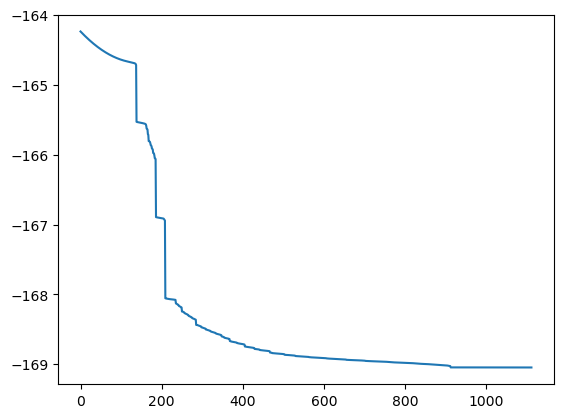

In [30]:
plt.plot(job_gb.output.energy_tot)

In [ ]:
job_gb.output.energy_tot

In [11]:
job_gb.output.cells[-1]

array([[ 1.96459866e+01, -1.95634587e-15,  1.20296973e-15],
       [-3.31749776e-32,  8.84807766e+00,  5.41788499e-16],
       [-1.71328567e-16, -1.71328567e-16,  2.79800783e+00]])

In [12]:
gb.get_cell()

Cell([[20.151473769366497, 0.0, 1.2339218924878265e-15], [1.4594898046764807e-15, 9.075736884683248, 5.557286062865456e-16], [0.0, 0.0, 2.8699999999999997]])